In [1]:
import torch
import math
from torch import nn
import pandas as pd
import numpy as np
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# define class for scale mixture gaussian prior
class ScaleMixtureGaussian:                               
    def __init__(self, mixture_weight, stddev_1, stddev_2):
        super().__init__()
        # mixture_weight is the weight for the first gaussian
        self.mixture_weight = mixture_weight
        # stddev_1 and stddev_2 are the standard deviations for the two gaussians
        self.stddev_1 = stddev_1
        self.stddev_2 = stddev_2
        # create two normal distributions with the specified standard deviations
        self.gaussian1 = torch.distributions.Normal(0,stddev_1)
        self.gaussian2 = torch.distributions.Normal(0,stddev_2)


    def log_prob(self, x):
        prob1 = torch.exp(self.gaussian1.log_prob(x))
        prob2 = torch.exp(self.gaussian2.log_prob(x))
        return (torch.log(self.mixture_weight * prob1 + (1-self.mixture_weight) * prob2)).sum()
    
# define class for gaussian node
class GaussianNode:
    def __init__(self, mean, rho_param):
        super().__init__()
        self.mean = mean
        self.rho_param = rho_param
        self.normal = torch.distributions.Normal(0,1)
    
    # Calculate the standard deviation from the rho parameter
    def sigma(self):
        return torch.log1p(torch.exp(self.rho_param))

    # Sample from the Gaussian node
    def sample(self):
        epsilon = self.normal.sample(self.rho_param.size()).cuda()
        return self.mean + self.sigma() * epsilon
    
    # Calculate the KL divergence between the prior and the variational posterior
    def log_prob(self, x):
        return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma()) - ((x - self.mean) ** 2) / (2 * self.sigma() ** 2)).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, mu_init, rho_init, prior_init):
        super().__init__()

        # Initialize the parameters for the weights and biases
        self.weight_mean = nn.Parameter(torch.empty(out_features, in_features).uniform_(*mu_init))
        self.weight_rho_param = nn.Parameter(torch.empty(out_features, in_features).uniform_(*rho_init))
        self.weight = GaussianNode(self.weight_mean, self.weight_rho_param)

        self.bias_mean = nn.Parameter(torch.empty(out_features).uniform_(*mu_init))
        self.bias_rho_param = nn.Parameter(torch.empty(out_features).uniform_(*rho_init))
        self.bias = GaussianNode(self.bias_mean, self.bias_rho_param)
        
        self.weight_prior = ScaleMixtureGaussian(prior_init[0], math.exp(prior_init[1]), math.exp(prior_init[2]))
        self.bias_prior = ScaleMixtureGaussian(prior_init[0], math.exp(prior_init[1]), math.exp(prior_init[2]))

        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x):
        weight = self.weight.sample()
        bias = self.bias.sample()

        return nn.functional.linear(x, weight, bias)

class BayesianNetwork(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']
        self.mu_init = model_params['mu_init']
        self.rho_init = model_params['rho_init']
        self.prior_init = model_params['prior_init']

        self.fc1 = BayesianLinear(self.input_shape, self.hidden_units, self.mu_init, self.rho_init, self.prior_init)
        self.fc1_activation = nn.ReLU()
        self.fc2 = BayesianLinear(self.hidden_units, self.hidden_units, self.mu_init, self.rho_init, self.prior_init)
        self.fc2_activation = nn.ReLU()
        self.fc3 = BayesianLinear(self.hidden_units, self.classes, self.mu_init, self.rho_init, self.prior_init)
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape) # Flatten images
        x = self.fc1_activation(self.fc1(x))
        x = self.fc2_activation(self.fc2(x))
        x = self.fc3(x)
        return x

    def log_prior(self):
        return self.fc1.log_prior + self.fc2.log_prior + self.fc3.log_prior
    
    def log_variational_posterior(self):
        return self.fc1.log_variational_posterior + self.fc2.log_variational_posterior + self.fc3.log_variational_posterior


    def get_nll(self, outputs, target, sigma=1.):
        if self.experiment == 'regression': #  -(.5 * (target - outputs) ** 2).sum()
            nll = -torch.distributions.Normal(outputs, sigma).log_prob(target).sum()
        elif self.experiment == 'classification':
            nll = nn.CrossEntropyLoss(reduction='sum')(outputs, target)
        return nll

    def sample_elbo(self, x, target, beta, samples, sigma=1.):
        log_prior = torch.zeros(1).to(device)
        log_variational_posterior = torch.zeros(1).to(device)
        negative_log_likelihood = torch.zeros(1).to(device)

        for i in range(samples):
            output = self.forward(x)
            log_prior += self.log_prior()
            log_variational_posterior += self.log_variational_posterior()
            negative_log_likelihood += self.get_nll(output, target, sigma)

        log_prior = beta*(log_prior / samples)
        log_variational_posterior = beta*(log_variational_posterior / samples) 
        negative_log_likelihood = negative_log_likelihood / samples
        loss = log_variational_posterior - log_prior + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood    


In [3]:
class MLP(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']

        self.net = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, self.classes))
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape) # Flatten images
        
        x = self.net(x)
        return x

class MLP_Dropout(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']

        self.net = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_units, self.hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_units, self.classes))
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape) # Flatten images
       
        x = self.net(x)
        return x

In [4]:
class RegConfig:
    train_size = 1024
    batch_size = 128
    lr = 1e-3
    epochs = 100 #1000
    train_samples = 5                   # number of train samples for MC gradients
    test_samples = 10                   # number of test samples for MC averaging
    num_test_points = 400               # number of test points
    experiment = 'regression'
    hidden_units = 400                  # number of hidden units
    noise_tolerance = .1                # log likelihood sigma
    mu_init = [-0.2, 0.2]               # range for mean 
    rho_init = [-5, -4]                 # range for rho_param
    prior_init = [0.5, -0, -6]        # mixture weight, log(stddev_1), log(stddev_2)
   

class RLConfig:
    data_dir = '/kaggle/input/mushroom-dataset/mushroom/agaricus-lepiota.data'
    batch_size = 64
    num_batches = 64
    buffer_size = batch_size * num_batches  # buffer to track latest batch of mushrooms
    lr = 1e-4
    training_steps = 10000
    experiment = 'regression'
    hidden_units = 100                      # number of hidden units
    mu_init = [-0.2, 0.2]                   # range for mu 
    rho_init = [-5, -4]                     # range for rho
    prior_init = [0.5, -0, -6]               # mixture weight, log(stddev_1), log(stddev_2)

class ClassConfig:
    batch_size = 128
    lr = 1e-3 # 1e-5 fa schifo, 1e-4 parte da 8% errore, 1e-3 parte da 5%
    epochs = 600 #100
    hidden_units = 1200
    experiment = 'classification'
    dropout = False
    train_samples = 1 # 10 è troppo lento
    test_samples = 10
    x_shape = 28 * 28                       # x shape
    classes = 10                            # number of output classes
    mu_init = [-0.2, 0.2]                   # range for mean 
    rho_init = [-5, -4]                     # range for rho_param
    prior_init = [0.75, 0, -7]             # mixture weight, log(stddev_1), log(stddev_2)

In [5]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y # vedere

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def read_data_rl(data_dir):
    '''
    Read in data for contextual bandits
    - transform context and label to one-hot encoded vectors
    '''
    df = pd.read_csv(data_dir, sep=',', header=None)
    df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
         'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
         'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
         'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']
    X = pd.DataFrame(df, columns=df.columns[1:len(df.columns)], index=df.index)
    Y = df['class']

    # transform to one-hot encoding
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(Y)
    Y_ = label_encoder.transform(Y)
    X_ = X.copy()
    for feature in X.columns:
        label_encoder.fit(X[feature])
        X_[feature] = label_encoder.transform(X[feature])

    oh_encoder = preprocessing.OneHotEncoder()
    oh_encoder.fit(X_)
    X_ = oh_encoder.transform(X_).toarray()

    return X_, Y_

def create_data_reg(train_size):
    np.random.seed(0)
    xs = np.random.uniform(low=0., high=0.6, size=train_size)
    
    eps = np.random.normal(loc=0., scale=0.02, size=[train_size])

    ys = xs + 0.3 * np.sin(2*np.pi * (xs + eps)) + 0.3 * np.sin(4*np.pi * (xs + eps)) + eps

    xs = torch.from_numpy(xs).reshape(-1,1).float()
    ys = torch.from_numpy(ys).reshape(-1,1).float()

    return xs, ys

In [6]:
# def load_bnn_class_model(saved_model):
#     config = ClassConfig

#     model_params = {
#         'input_shape': config.x_shape,
#         'classes': config.classes,
#         'batch_size': config.batch_size,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'mu_init': config.mu_init,
#         'rho_init': config.rho_init,
#         'prior_init': config.prior_init
#     }
#     model = BayesianNetwork(model_params)
#     model.load_state_dict(torch.load(saved_model))

#     return model.eval()

# def load_mlp_class_model(saved_model):
#     config = ClassConfig
#     model_params = {
#         'input_shape': config.x_shape,
#         'classes': config.classes,
#         'batch_size': config.batch_size,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#     }
#     model = MLP(model_params)
#     model.load_state_dict(torch.load(saved_model))

#     return model.eval()

# def load_dropout_class_model(saved_model):
#     config = ClassConfig
#     model_params = {
#         'input_shape': config.x_shape,
#         'classes': config.classes,
#         'batch_size': config.batch_size,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'dropout': True
#     }
#     model = MLP_Dropout(model_params)
#     model.load_state_dict(torch.load(saved_model))

#     return model.eval()

In [7]:
def create_regression_plot(X_test, y_test, train_ds):
    fig = plt.figure(figsize=(9, 6))
    plt.plot(X_test, np.median(y_test, axis=0), label='Median Posterior Predictive')
    
    # Range
    plt.fill_between(
        X_test.reshape(-1), 
        np.percentile(y_test, 0, axis=0), 
        np.percentile(y_test, 100, axis=0), 
        alpha = 0.2, color='orange', label='Range') #color='blue',
    
    # interquartile range
    plt.fill_between(
        X_test.reshape(-1), 
        np.percentile(y_test, 25, axis=0), 
        np.percentile(y_test, 75, axis=0), 
        alpha = 0.4,  label='Interquartile Range') #color='red',
    
    plt.scatter(train_ds.dataset.X, train_ds.dataset.y, label='Training data', marker='x', alpha=0.5, color='k', s=2)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim([-1.5, 1.5])
    plt.xlim([-0.6, 1.4])

   

In [8]:
class BNN_Classification():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.classes = parameters['classes']
        self.mu_init = parameters['mu_init']
        self.rho_init = parameters['rho_init']
        self.prior_init = parameters['prior_init']
        self.best_acc = 0.
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.classes,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment,
            'mu_init': self.mu_init,
            'rho_init': self.rho_init,
            'prior_init': self.prior_init,
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=100, gamma=0.5)
        # print(f'Classification Task {self.label} Parameters: ')
        # print(f'number of samples: {self.n_samples}')
        # print("BNN Parameters: ")
        # print(f'batch size: {self.batch_size}, x shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def train_step(self, train_data):
        self.net.train()
        for idx, (x, y) in enumerate(tqdm(train_data)):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1) 
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples)            
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()

    def predict(self, X):
        probs = torch.zeros(size=[self.batch_size, self.classes]).to(device)
        for _ in torch.arange(self.test_samples):
            out = torch.nn.Softmax(dim=1)(self.net(X))
            probs = probs + out / self.test_samples
        preds = torch.argmax(probs, dim=1)
        return preds, probs

    def evaluate(self, test_loader):
        self.net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(test_loader):
                X, y = data
                X, y = X.to(device), y.to(device)
                preds, _ = self.predict(X)
                total += self.batch_size
                correct += (preds == y).sum().item()
        self.acc = correct / total
        print(f'{self.label} validation accuracy: {self.acc}')  
        return self.acc


In [9]:
class MLP_Classification():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.classes = parameters['classes']
        self.best_acc = 0.
        self.dropout = parameters['dropout']
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.classes,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment,
            'dropout': self.dropout,
        }
        if self.dropout:
            self.net = MLP_Dropout(model_params).to(device)
        else:
            self.net = MLP(model_params).to(device)
        
        self.optimiser = torch.optim.SGD(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=100, gamma=0.5)

    def train_step(self, train_data):
        self.net.train()
        for _, (x, y) in enumerate(tqdm(train_data)):
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = torch.nn.functional.cross_entropy(self.net(x), y, reduction='sum')
            self.loss_info.backward()
            self.optimiser.step()

    def predict(self, X):
        probs = torch.nn.Softmax(dim=1)(self.net(X))
        preds = torch.argmax(probs, dim=1)
        return preds, probs

    def evaluate(self, test_loader):
        self.net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(test_loader):
                X, y = data
                X, y = X.to(device), y.to(device)
                preds, _ = self.predict(X)
                total += self.batch_size
                correct += (preds == y).sum().item()
        self.acc = correct / total
        print(f'{self.label} validation accuracy: {self.acc}') 
        return self.acc

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.48MB/s]


Epoch 1/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9495192307692307


100%|██████████| 78/78 [00:01<00:00, 70.42it/s]


mlp_classification validation accuracy: 0.9509214743589743


100%|██████████| 78/78 [00:01<00:00, 70.47it/s]


mlp_dropout_classification validation accuracy: 0.9486177884615384
BNN Test Error: 5.05%
MLP Test Error: 4.91%
MLP Dropout Test Error: 5.14%
Epoch 2/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9488181089743589


100%|██████████| 78/78 [00:01<00:00, 69.06it/s]


mlp_classification validation accuracy: 0.9660456730769231


100%|██████████| 78/78 [00:01<00:00, 73.73it/s]


mlp_dropout_classification validation accuracy: 0.9660456730769231
BNN Test Error: 5.12%
MLP Test Error: 3.40%
MLP Dropout Test Error: 3.40%
Epoch 3/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9676482371794872


100%|██████████| 78/78 [00:01<00:00, 72.12it/s]


mlp_classification validation accuracy: 0.9692508012820513


100%|██████████| 78/78 [00:01<00:00, 72.49it/s]


mlp_dropout_classification validation accuracy: 0.9701522435897436
BNN Test Error: 3.24%
MLP Test Error: 3.07%
MLP Dropout Test Error: 2.98%
Epoch 4/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9696514423076923


100%|██████████| 78/78 [00:01<00:00, 73.11it/s]


mlp_classification validation accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_dropout_classification validation accuracy: 0.9743589743589743
BNN Test Error: 3.03%
MLP Test Error: 2.43%
MLP Dropout Test Error: 2.56%
Epoch 5/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9713541666666666


100%|██████████| 78/78 [00:01<00:00, 71.51it/s]


mlp_classification validation accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:01<00:00, 71.59it/s]


mlp_dropout_classification validation accuracy: 0.9772636217948718
BNN Test Error: 2.86%
MLP Test Error: 2.27%
MLP Dropout Test Error: 2.27%
Epoch 6/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:01<00:00, 71.83it/s]


mlp_classification validation accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:01<00:00, 70.90it/s]


mlp_dropout_classification validation accuracy: 0.9759615384615384
BNN Test Error: 2.29%
MLP Test Error: 2.24%
MLP Dropout Test Error: 2.40%
Epoch 7/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.967948717948718


100%|██████████| 78/78 [00:01<00:00, 71.73it/s]


mlp_classification validation accuracy: 0.9802684294871795


100%|██████████| 78/78 [00:01<00:00, 71.50it/s]


mlp_dropout_classification validation accuracy: 0.9787660256410257
BNN Test Error: 3.21%
MLP Test Error: 1.97%
MLP Dropout Test Error: 2.12%
Epoch 8/600


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


bnn_classification validation accuracy: 0.9739583333333334


100%|██████████| 78/78 [00:01<00:00, 70.84it/s]


mlp_classification validation accuracy: 0.9787660256410257


100%|██████████| 78/78 [00:01<00:00, 72.68it/s]


mlp_dropout_classification validation accuracy: 0.9806690705128205
BNN Test Error: 2.60%
MLP Test Error: 2.12%
MLP Dropout Test Error: 1.93%
Epoch 9/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9725560897435898


100%|██████████| 78/78 [00:01<00:00, 71.66it/s]


mlp_classification validation accuracy: 0.9819711538461539


100%|██████████| 78/78 [00:01<00:00, 71.21it/s]


mlp_dropout_classification validation accuracy: 0.981270032051282
BNN Test Error: 2.74%
MLP Test Error: 1.80%
MLP Dropout Test Error: 1.87%
Epoch 10/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9717548076923077


100%|██████████| 78/78 [00:01<00:00, 71.50it/s]


mlp_classification validation accuracy: 0.9823717948717948


100%|██████████| 78/78 [00:01<00:00, 72.36it/s]


mlp_dropout_classification validation accuracy: 0.9827724358974359
BNN Test Error: 2.82%
MLP Test Error: 1.76%
MLP Dropout Test Error: 1.72%
Epoch 11/600


100%|██████████| 78/78 [00:16<00:00,  4.64it/s]


bnn_classification validation accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:01<00:00, 71.40it/s]


mlp_classification validation accuracy: 0.9829727564102564


100%|██████████| 78/78 [00:01<00:00, 70.80it/s]


mlp_dropout_classification validation accuracy: 0.9829727564102564
BNN Test Error: 2.29%
MLP Test Error: 1.70%
MLP Dropout Test Error: 1.70%
Epoch 12/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:01<00:00, 66.01it/s]


mlp_classification validation accuracy: 0.9815705128205128


100%|██████████| 78/78 [00:01<00:00, 70.43it/s]


mlp_dropout_classification validation accuracy: 0.9831730769230769
BNN Test Error: 2.44%
MLP Test Error: 1.84%
MLP Dropout Test Error: 1.68%
Epoch 13/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:01<00:00, 69.95it/s]


mlp_classification validation accuracy: 0.9827724358974359


100%|██████████| 78/78 [00:01<00:00, 70.26it/s]


mlp_dropout_classification validation accuracy: 0.9838741987179487
BNN Test Error: 2.63%
MLP Test Error: 1.72%
MLP Dropout Test Error: 1.61%
Epoch 14/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:01<00:00, 65.37it/s]


mlp_classification validation accuracy: 0.9830729166666666


100%|██████████| 78/78 [00:01<00:00, 71.48it/s]


mlp_dropout_classification validation accuracy: 0.9821714743589743
BNN Test Error: 2.33%
MLP Test Error: 1.69%
MLP Dropout Test Error: 1.78%
Epoch 15/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9692508012820513


100%|██████████| 78/78 [00:01<00:00, 72.05it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 72.04it/s]


mlp_dropout_classification validation accuracy: 0.9833733974358975
BNN Test Error: 3.07%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.66%
Epoch 16/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:01<00:00, 72.58it/s]


mlp_classification validation accuracy: 0.9830729166666666


100%|██████████| 78/78 [00:01<00:00, 72.21it/s]


mlp_dropout_classification validation accuracy: 0.9846754807692307
BNN Test Error: 2.49%
MLP Test Error: 1.69%
MLP Dropout Test Error: 1.53%
Epoch 17/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:01<00:00, 70.69it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 73.20it/s]


mlp_dropout_classification validation accuracy: 0.9832732371794872
BNN Test Error: 2.45%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.67%
Epoch 18/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:01<00:00, 72.30it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.63it/s]


mlp_dropout_classification validation accuracy: 0.9847756410256411
BNN Test Error: 2.48%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.52%
Epoch 19/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9791666666666666


100%|██████████| 78/78 [00:01<00:00, 71.29it/s]


mlp_classification validation accuracy: 0.9830729166666666


100%|██████████| 78/78 [00:01<00:00, 68.24it/s]


mlp_dropout_classification validation accuracy: 0.9850761217948718
BNN Test Error: 2.08%
MLP Test Error: 1.69%
MLP Dropout Test Error: 1.49%
Epoch 20/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9794671474358975


100%|██████████| 78/78 [00:01<00:00, 70.85it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 71.45it/s]


mlp_dropout_classification validation accuracy: 0.9853766025641025
BNN Test Error: 2.05%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.46%
Epoch 21/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:01<00:00, 71.30it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.82it/s]


mlp_dropout_classification validation accuracy: 0.9841746794871795
BNN Test Error: 2.14%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.58%
Epoch 22/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.979667467948718


100%|██████████| 78/78 [00:01<00:00, 73.05it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 73.06it/s]


mlp_dropout_classification validation accuracy: 0.984375
BNN Test Error: 2.03%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.56%
Epoch 23/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:01<00:00, 72.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.00it/s]


mlp_dropout_classification validation accuracy: 0.9852764423076923
BNN Test Error: 2.22%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.47%
Epoch 24/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9816706730769231


100%|██████████| 78/78 [00:01<00:00, 72.31it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.02it/s]


mlp_dropout_classification validation accuracy: 0.9852764423076923
BNN Test Error: 1.83%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.47%
Epoch 25/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9786658653846154


100%|██████████| 78/78 [00:01<00:00, 72.39it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.83it/s]


mlp_dropout_classification validation accuracy: 0.9854767628205128
BNN Test Error: 2.13%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.45%
Epoch 26/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9794671474358975


100%|██████████| 78/78 [00:01<00:00, 70.79it/s]


mlp_classification validation accuracy: 0.9837740384615384


100%|██████████| 78/78 [00:01<00:00, 70.68it/s]


mlp_dropout_classification validation accuracy: 0.9864783653846154
BNN Test Error: 2.05%
MLP Test Error: 1.62%
MLP Dropout Test Error: 1.35%
Epoch 27/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:01<00:00, 68.67it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.08it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 2.22%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.39%
Epoch 28/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9814703525641025


100%|██████████| 78/78 [00:01<00:00, 70.72it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 72.85it/s]


mlp_dropout_classification validation accuracy: 0.9857772435897436
BNN Test Error: 1.85%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.42%
Epoch 29/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9813701923076923


100%|██████████| 78/78 [00:01<00:00, 71.17it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.94it/s]


mlp_dropout_classification validation accuracy: 0.9841746794871795
BNN Test Error: 1.86%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.58%
Epoch 30/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:01<00:00, 72.84it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 72.48it/s]


mlp_dropout_classification validation accuracy: 0.984375
BNN Test Error: 2.27%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.56%
Epoch 31/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:01<00:00, 71.70it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.41it/s]


mlp_dropout_classification validation accuracy: 0.9853766025641025
BNN Test Error: 2.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.46%
Epoch 32/600


100%|██████████| 78/78 [00:16<00:00,  4.59it/s]


bnn_classification validation accuracy: 0.9791666666666666


100%|██████████| 78/78 [00:01<00:00, 68.25it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.85it/s]


mlp_dropout_classification validation accuracy: 0.9854767628205128
BNN Test Error: 2.08%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.45%
Epoch 33/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9809695512820513


100%|██████████| 78/78 [00:01<00:00, 69.92it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 71.94it/s]


mlp_dropout_classification validation accuracy: 0.9855769230769231
BNN Test Error: 1.90%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.44%
Epoch 34/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9801682692307693


100%|██████████| 78/78 [00:01<00:00, 72.72it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.99it/s]


mlp_dropout_classification validation accuracy: 0.984375
BNN Test Error: 1.98%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.56%
Epoch 35/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9817708333333334


100%|██████████| 78/78 [00:01<00:00, 71.17it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.04it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 1.82%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.37%
Epoch 36/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9809695512820513


100%|██████████| 78/78 [00:01<00:00, 71.48it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 70.79it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.90%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.36%
Epoch 37/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9802684294871795


100%|██████████| 78/78 [00:01<00:00, 68.82it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.76it/s]


mlp_dropout_classification validation accuracy: 0.9859775641025641
BNN Test Error: 1.97%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.40%
Epoch 38/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9779647435897436


100%|██████████| 78/78 [00:01<00:00, 71.81it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 70.16it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 2.20%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.34%
Epoch 39/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.98046875


100%|██████████| 78/78 [00:01<00:00, 70.18it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 66.19it/s]


mlp_dropout_classification validation accuracy: 0.9855769230769231
BNN Test Error: 1.95%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.44%
Epoch 40/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:01<00:00, 71.83it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.09it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 2.15%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.37%
Epoch 41/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.9815705128205128


100%|██████████| 78/78 [00:01<00:00, 71.56it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.44it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.84%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 42/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:01<00:00, 68.66it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 64.34it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 2.18%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.33%
Epoch 43/600


100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


bnn_classification validation accuracy: 0.9818709935897436


100%|██████████| 78/78 [00:01<00:00, 72.85it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.69it/s]


mlp_dropout_classification validation accuracy: 0.9850761217948718
BNN Test Error: 1.81%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.49%
Epoch 44/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9818709935897436


100%|██████████| 78/78 [00:01<00:00, 71.72it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 72.56it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 1.81%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.39%
Epoch 45/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9819711538461539


100%|██████████| 78/78 [00:01<00:00, 70.60it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.10it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.80%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.36%
Epoch 46/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.96it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 2.14%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.39%
Epoch 47/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9821714743589743


100%|██████████| 78/78 [00:01<00:00, 69.58it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 69.56it/s]


mlp_dropout_classification validation accuracy: 0.9856770833333334
BNN Test Error: 1.78%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.43%
Epoch 48/600


100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


bnn_classification validation accuracy: 0.9798677884615384


100%|██████████| 78/78 [00:01<00:00, 68.37it/s]


mlp_classification validation accuracy: 0.9837740384615384


100%|██████████| 78/78 [00:01<00:00, 70.40it/s]


mlp_dropout_classification validation accuracy: 0.9855769230769231
BNN Test Error: 2.01%
MLP Test Error: 1.62%
MLP Dropout Test Error: 1.44%
Epoch 49/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9801682692307693


100%|██████████| 78/78 [00:01<00:00, 68.34it/s]


mlp_classification validation accuracy: 0.9837740384615384


100%|██████████| 78/78 [00:01<00:00, 71.50it/s]


mlp_dropout_classification validation accuracy: 0.9856770833333334
BNN Test Error: 1.98%
MLP Test Error: 1.62%
MLP Dropout Test Error: 1.43%
Epoch 50/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9827724358974359


100%|██████████| 78/78 [00:01<00:00, 70.71it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.80it/s]


mlp_dropout_classification validation accuracy: 0.9853766025641025
BNN Test Error: 1.72%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.46%
Epoch 51/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.9787660256410257


100%|██████████| 78/78 [00:01<00:00, 69.69it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.85it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 2.12%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.39%
Epoch 52/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9801682692307693


100%|██████████| 78/78 [00:01<00:00, 71.52it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.11it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.98%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.34%
Epoch 53/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9797676282051282


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.49it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 2.02%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.33%
Epoch 54/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9808693910256411


100%|██████████| 78/78 [00:01<00:00, 69.85it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 71.66it/s]


mlp_dropout_classification validation accuracy: 0.9857772435897436
BNN Test Error: 1.91%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.42%
Epoch 55/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.981270032051282


100%|██████████| 78/78 [00:01<00:00, 71.83it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.91it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 1.87%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.39%
Epoch 56/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9792668269230769


100%|██████████| 78/78 [00:01<00:00, 71.00it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 71.07it/s]


mlp_dropout_classification validation accuracy: 0.9859775641025641
BNN Test Error: 2.07%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.40%
Epoch 57/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:01<00:00, 71.75it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.08it/s]


mlp_dropout_classification validation accuracy: 0.9857772435897436
BNN Test Error: 2.06%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.42%
Epoch 58/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:01<00:00, 70.78it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.41it/s]


mlp_dropout_classification validation accuracy: 0.9857772435897436
BNN Test Error: 2.15%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.42%
Epoch 59/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9803685897435898


100%|██████████| 78/78 [00:01<00:00, 72.81it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.72it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.96%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.36%
Epoch 60/600


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


bnn_classification validation accuracy: 0.9795673076923077


100%|██████████| 78/78 [00:01<00:00, 72.64it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.12it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 2.04%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.36%
Epoch 61/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9829727564102564


100%|██████████| 78/78 [00:01<00:00, 71.23it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.11it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 1.70%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.37%
Epoch 62/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9800681089743589


100%|██████████| 78/78 [00:01<00:00, 72.50it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 71.32it/s]


mlp_dropout_classification validation accuracy: 0.9853766025641025
BNN Test Error: 1.99%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.46%
Epoch 63/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9805689102564102


100%|██████████| 78/78 [00:01<00:00, 67.32it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 70.07it/s]


mlp_dropout_classification validation accuracy: 0.9858774038461539
BNN Test Error: 1.94%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.41%
Epoch 64/600


100%|██████████| 78/78 [00:16<00:00,  4.61it/s]


bnn_classification validation accuracy: 0.9800681089743589


100%|██████████| 78/78 [00:01<00:00, 69.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.76it/s]


mlp_dropout_classification validation accuracy: 0.9858774038461539
BNN Test Error: 1.99%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.41%
Epoch 65/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.18it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.76it/s]


mlp_dropout_classification validation accuracy: 0.9850761217948718
BNN Test Error: 1.66%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.49%
Epoch 66/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9810697115384616


100%|██████████| 78/78 [00:01<00:00, 71.26it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.74it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.89%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.32%
Epoch 67/600


100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


bnn_classification validation accuracy: 0.9830729166666666


100%|██████████| 78/78 [00:01<00:00, 71.58it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.34it/s]


mlp_dropout_classification validation accuracy: 0.9856770833333334
BNN Test Error: 1.69%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.43%
Epoch 68/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9805689102564102


100%|██████████| 78/78 [00:01<00:00, 72.21it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.08it/s]


mlp_dropout_classification validation accuracy: 0.9861778846153846
BNN Test Error: 1.94%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.38%
Epoch 69/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9818709935897436


100%|██████████| 78/78 [00:01<00:00, 69.87it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.40it/s]


mlp_dropout_classification validation accuracy: 0.9858774038461539
BNN Test Error: 1.81%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.41%
Epoch 70/600


100%|██████████| 78/78 [00:17<00:00,  4.50it/s]


bnn_classification validation accuracy: 0.9819711538461539


100%|██████████| 78/78 [00:01<00:00, 73.09it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.72it/s]


mlp_dropout_classification validation accuracy: 0.9850761217948718
BNN Test Error: 1.80%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.49%
Epoch 71/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 72.89it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.63%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 72/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9829727564102564


100%|██████████| 78/78 [00:01<00:00, 73.85it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.11it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.70%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.33%
Epoch 73/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9817708333333334


100%|██████████| 78/78 [00:01<00:00, 73.45it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.17it/s]


mlp_dropout_classification validation accuracy: 0.9858774038461539
BNN Test Error: 1.82%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.41%
Epoch 74/600


100%|██████████| 78/78 [00:17<00:00,  4.57it/s]


bnn_classification validation accuracy: 0.9827724358974359


100%|██████████| 78/78 [00:01<00:00, 70.15it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 73.61it/s]


mlp_dropout_classification validation accuracy: 0.9859775641025641
BNN Test Error: 1.72%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.40%
Epoch 75/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9815705128205128


100%|██████████| 78/78 [00:01<00:00, 71.44it/s]


mlp_classification validation accuracy: 0.9836738782051282


100%|██████████| 78/78 [00:01<00:00, 70.20it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.84%
MLP Test Error: 1.63%
MLP Dropout Test Error: 1.32%
Epoch 76/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9809695512820513


100%|██████████| 78/78 [00:01<00:00, 65.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.84it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 1.90%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.39%
Epoch 77/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:01<00:00, 73.33it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.80it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 2.16%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.32%
Epoch 78/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9820713141025641


100%|██████████| 78/78 [00:01<00:00, 73.65it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.77it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.79%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 79/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9824719551282052


100%|██████████| 78/78 [00:01<00:00, 72.48it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.32it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 1.75%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.37%
Epoch 80/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9803685897435898


100%|██████████| 78/78 [00:01<00:00, 69.72it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.39it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.96%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.32%
Epoch 81/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9802684294871795


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.62it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 1.97%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.39%
Epoch 82/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9828725961538461


100%|██████████| 78/78 [00:01<00:00, 71.42it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.98it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.71%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 83/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9803685897435898


100%|██████████| 78/78 [00:01<00:00, 72.60it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.83it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.96%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.23%
Epoch 84/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 71.95it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.68it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.44%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.24%
Epoch 85/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9820713141025641


100%|██████████| 78/78 [00:01<00:00, 72.70it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.09it/s]


mlp_dropout_classification validation accuracy: 0.9860777243589743
BNN Test Error: 1.79%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.39%
Epoch 86/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.981270032051282


100%|██████████| 78/78 [00:01<00:00, 70.29it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 1.87%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.37%
Epoch 87/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9826722756410257


100%|██████████| 78/78 [00:01<00:00, 73.03it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.91it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.73%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.33%
Epoch 88/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.9814703525641025


100%|██████████| 78/78 [00:01<00:00, 73.60it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.16it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.85%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.36%
Epoch 89/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9824719551282052


100%|██████████| 78/78 [00:01<00:00, 72.50it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 73.54it/s]


mlp_dropout_classification validation accuracy: 0.9856770833333334
BNN Test Error: 1.75%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.43%
Epoch 90/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9815705128205128


100%|██████████| 78/78 [00:01<00:00, 67.86it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 73.47it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.84%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.34%
Epoch 91/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9823717948717948


100%|██████████| 78/78 [00:01<00:00, 73.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.48it/s]


mlp_dropout_classification validation accuracy: 0.9856770833333334
BNN Test Error: 1.76%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.43%
Epoch 92/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9805689102564102


100%|██████████| 78/78 [00:01<00:00, 69.87it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.36it/s]


mlp_dropout_classification validation accuracy: 0.9861778846153846
BNN Test Error: 1.94%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.38%
Epoch 93/600


100%|██████████| 78/78 [00:17<00:00,  4.50it/s]


bnn_classification validation accuracy: 0.9828725961538461


100%|██████████| 78/78 [00:01<00:00, 72.58it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 67.53it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.71%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.34%
Epoch 94/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9810697115384616


100%|██████████| 78/78 [00:01<00:00, 71.40it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 70.08it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 1.89%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.37%
Epoch 95/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9799679487179487


100%|██████████| 78/78 [00:01<00:00, 72.73it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.87it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 2.00%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.34%
Epoch 96/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9825721153846154


100%|██████████| 78/78 [00:01<00:00, 71.79it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.08it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.74%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.34%
Epoch 97/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9824719551282052


100%|██████████| 78/78 [00:01<00:00, 72.39it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.73it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.75%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.32%
Epoch 98/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.9837740384615384


100%|██████████| 78/78 [00:01<00:00, 72.23it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 72.63it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.62%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.34%
Epoch 99/600


100%|██████████| 78/78 [00:17<00:00,  4.50it/s]


bnn_classification validation accuracy: 0.9823717948717948


100%|██████████| 78/78 [00:01<00:00, 72.21it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.34it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.76%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 100/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9825721153846154


100%|██████████| 78/78 [00:01<00:00, 69.18it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.13it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.74%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 101/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9846754807692307


100%|██████████| 78/78 [00:01<00:00, 70.91it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.87it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.53%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.31%
Epoch 102/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9838741987179487


100%|██████████| 78/78 [00:01<00:00, 71.91it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.15it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.61%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 103/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 72.44it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.49%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.27%
Epoch 104/600


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 68.61it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 69.44it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.50%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.24%
Epoch 105/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9845753205128205


100%|██████████| 78/78 [00:01<00:00, 70.52it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.54%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.26%
Epoch 106/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 72.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.51%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 107/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9847756410256411


100%|██████████| 78/78 [00:01<00:00, 72.42it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.75it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.52%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.28%
Epoch 108/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9847756410256411


100%|██████████| 78/78 [00:01<00:00, 72.65it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.21it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.52%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.24%
Epoch 109/600


100%|██████████| 78/78 [00:16<00:00,  4.59it/s]


bnn_classification validation accuracy: 0.9846754807692307


100%|██████████| 78/78 [00:01<00:00, 72.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.76it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.53%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 110/600


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 71.39it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 73.15it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.49%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.26%
Epoch 111/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9847756410256411


100%|██████████| 78/78 [00:01<00:00, 70.30it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.71it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.52%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 112/600


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 72.70it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 72.09it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.49%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.29%
Epoch 113/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9845753205128205


100%|██████████| 78/78 [00:01<00:00, 70.91it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.16it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.54%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.25%
Epoch 114/600


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


bnn_classification validation accuracy: 0.9844751602564102


100%|██████████| 78/78 [00:01<00:00, 70.43it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.86it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.55%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 115/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9846754807692307


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.82it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.53%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 116/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 63.25it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.47it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.51%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.27%
Epoch 117/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 71.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.10it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 118/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9846754807692307


100%|██████████| 78/78 [00:01<00:00, 66.95it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.86it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.53%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 119/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 67.40it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.18it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 120/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 67.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.47it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 121/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9847756410256411


100%|██████████| 78/78 [00:01<00:00, 72.25it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.43it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.52%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 122/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.18it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 123/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 71.46it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.11it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 124/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 72.20it/s]


mlp_classification validation accuracy: 0.9831730769230769


100%|██████████| 78/78 [00:01<00:00, 69.54it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.50%
MLP Test Error: 1.68%
MLP Dropout Test Error: 1.23%
Epoch 125/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 73.14it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.99it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.50%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 126/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 72.55it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.15it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.51%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 127/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 71.08it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.90it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.51%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 128/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 72.47it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.91it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.47%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.27%
Epoch 129/600


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 71.80it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.59it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 130/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 67.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.79it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 131/600


100%|██████████| 78/78 [00:17<00:00,  4.54it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 70.34it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.85it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 132/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 72.46it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 133/600


100%|██████████| 78/78 [00:17<00:00,  4.54it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 71.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 134/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 73.52it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.32it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.21%
Epoch 135/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 73.54it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.74it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 136/600


100%|██████████| 78/78 [00:16<00:00,  4.61it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 71.94it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.69it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 137/600


100%|██████████| 78/78 [00:17<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 74.22it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.98it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.46%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.23%
Epoch 138/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 73.29it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.06it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 139/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 66.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.83it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 140/600


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 73.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.01it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.45%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 141/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 72.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.93it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.45%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 142/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 69.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.02it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 143/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 68.52it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.32it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.46%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 144/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 68.67it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.23it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 145/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 69.44it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.04it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.46%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 146/600


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 72.80it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.55it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.47%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 147/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 71.36it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 68.95it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.46%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.25%
Epoch 148/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 72.47it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.02it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.45%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 149/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 73.43it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.18it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 150/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 72.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.31it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 151/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 71.19it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.22it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 152/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 68.41it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 68.98it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.48%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.30%
Epoch 153/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 72.29it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.62it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.44%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.31%
Epoch 154/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 72.26it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 73.06it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.47%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.29%
Epoch 155/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 67.76it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 68.28it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.44%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 156/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 68.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.18it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 157/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 69.97it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.76it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.48%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 158/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 71.58it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.36it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 159/600


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 72.47it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.49it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 160/600


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


bnn_classification validation accuracy: 0.9827724358974359


100%|██████████| 78/78 [00:01<00:00, 72.58it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 73.40it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.72%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.27%
Epoch 161/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9844751602564102


100%|██████████| 78/78 [00:01<00:00, 72.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.81it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.55%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 162/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9860777243589743


100%|██████████| 78/78 [00:01<00:00, 72.96it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 74.11it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.39%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 163/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 71.54it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.28it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 164/600


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


bnn_classification validation accuracy: 0.9858774038461539


100%|██████████| 78/78 [00:01<00:00, 71.05it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.43it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.41%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.30%
Epoch 165/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9844751602564102


100%|██████████| 78/78 [00:01<00:00, 71.24it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.59it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.55%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 166/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 72.90it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.80it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 167/600


100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 67.63it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 68.55it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.22%
Epoch 168/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9856770833333334


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.41it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.43%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 169/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 73.85it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.71it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.44%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.24%
Epoch 170/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 72.80it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.24it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.23%
Epoch 171/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 68.49it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.76it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.48%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 172/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9858774038461539


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.80it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.41%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 173/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.9856770833333334


100%|██████████| 78/78 [00:01<00:00, 73.26it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.24it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.43%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 174/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 66.33it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 68.43it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 175/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 72.72it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 67.81it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.30%
Epoch 176/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 68.83it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 68.44it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.44%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.24%
Epoch 177/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 72.81it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 74.01it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.46%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.30%
Epoch 178/600


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 73.03it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.39it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.44%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 179/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 71.56it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.68it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.44%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.31%
Epoch 180/600


100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 71.07it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.87it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.48%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.33%
Epoch 181/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 74.17it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.38it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 182/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9847756410256411


100%|██████████| 78/78 [00:01<00:00, 72.42it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.70it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.52%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 183/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 73.38it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 74.25it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.44%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 184/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.67it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.48%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.33%
Epoch 185/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 72.54it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.16it/s]


mlp_dropout_classification validation accuracy: 0.9862780448717948
BNN Test Error: 1.50%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.37%
Epoch 186/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 67.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.00it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.36%
Epoch 187/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 72.02it/s]


mlp_classification validation accuracy: 0.983573717948718


100%|██████████| 78/78 [00:01<00:00, 72.05it/s]


mlp_dropout_classification validation accuracy: 0.9857772435897436
BNN Test Error: 1.47%
MLP Test Error: 1.64%
MLP Dropout Test Error: 1.42%
Epoch 188/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 73.26it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.62it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 189/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 70.04it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.69it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.47%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.34%
Epoch 190/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 71.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.52it/s]


mlp_dropout_classification validation accuracy: 0.9864783653846154
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.35%
Epoch 191/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 70.59it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.13it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.45%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 192/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 72.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.56it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 193/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9855769230769231


100%|██████████| 78/78 [00:01<00:00, 71.06it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.77it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.44%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 194/600


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 68.46it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.69it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.48%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 195/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 70.32it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.69it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.46%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.30%
Epoch 196/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 70.30it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.63it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 197/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 67.27it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 67.58it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.49%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.32%
Epoch 198/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 70.87it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.22it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 199/600


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 72.37it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.27it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 200/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 71.23it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.76it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.49%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 201/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 70.51it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.33it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.51%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.33%
Epoch 202/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 70.87it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.74it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 203/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 72.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.40it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 204/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 71.10it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.66it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.47%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.33%
Epoch 205/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 73.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.19it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.51%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 206/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 72.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.49it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 207/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 71.91it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.81it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 208/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 66.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.12it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 209/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 73.44it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.82it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 210/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.17it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.34%
Epoch 211/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 73.75it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.54it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.36%
Epoch 212/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 69.87it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.86it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 213/600


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 73.25it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.07it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 214/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.88it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 215/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 73.18it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.89it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.34%
Epoch 216/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9852764423076923


100%|██████████| 78/78 [00:01<00:00, 72.52it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.11it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.47%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 217/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 72.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.76it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 218/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 72.10it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.10it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 219/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9848758012820513


100%|██████████| 78/78 [00:01<00:00, 72.06it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.56it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.51%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 220/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 70.42it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.07it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 221/600


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 72.67it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.31it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.33%
Epoch 222/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 55.91it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 55.81it/s]


mlp_dropout_classification validation accuracy: 0.9863782051282052
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.36%
Epoch 223/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 70.26it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.30it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.48%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 224/600


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 69.02it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.84it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.45%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 225/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 72.08it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 66.01it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.46%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 226/600


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 69.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.38it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 227/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 71.56it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 228/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 70.79it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.11it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 229/600


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


bnn_classification validation accuracy: 0.9849759615384616


100%|██████████| 78/78 [00:01<00:00, 71.13it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.74it/s]


mlp_dropout_classification validation accuracy: 0.9867788461538461
BNN Test Error: 1.50%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.32%
Epoch 230/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 70.24it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.34it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 231/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.985176282051282


100%|██████████| 78/78 [00:01<00:00, 69.14it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.53it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.48%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.29%
Epoch 232/600


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


bnn_classification validation accuracy: 0.9854767628205128


100%|██████████| 78/78 [00:01<00:00, 70.53it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.28it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.45%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 233/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 72.40it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.17it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.49%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 234/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 72.12it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.53it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 235/600


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


bnn_classification validation accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:01<00:00, 71.73it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.39it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.46%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 236/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9858774038461539


100%|██████████| 78/78 [00:01<00:00, 67.03it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 69.68it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.41%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 237/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9850761217948718


100%|██████████| 78/78 [00:01<00:00, 73.32it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.22it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.49%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 238/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.984375


100%|██████████| 78/78 [00:01<00:00, 70.35it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.60it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.56%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 239/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.78it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.19it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 240/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.14it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 66.16it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.23%
Epoch 241/600


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.34it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.47it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 242/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.30it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 49.53it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 243/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.17it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.54it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 244/600


100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 68.49it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.69it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 245/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.71it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 67.82it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 246/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 68.96it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 69.21it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.35%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.31%
Epoch 247/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.30it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 248/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 66.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.59it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 249/600


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.44it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.57it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.33%
Epoch 250/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 73.12it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.34it/s]


mlp_dropout_classification validation accuracy: 0.9866786858974359
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.33%
Epoch 251/600


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.47it/s]


mlp_dropout_classification validation accuracy: 0.9864783653846154
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.35%
Epoch 252/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.07it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 71.85it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.32%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.29%
Epoch 253/600


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 73.18it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.31it/s]


mlp_dropout_classification validation accuracy: 0.9865785256410257
BNN Test Error: 1.34%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.34%
Epoch 254/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.01it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.75it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.35%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 255/600


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.88it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 69.19it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.35%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 256/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.24it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.05it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 257/600


100%|██████████| 78/78 [00:19<00:00,  4.11it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.97it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.56it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 258/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.43it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.97it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.25%
Epoch 259/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 73.04it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.06it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 260/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.46it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.74it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 261/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9869791666666666


100%|██████████| 78/78 [00:01<00:00, 72.91it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.50it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.30%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.24%
Epoch 262/600


100%|██████████| 78/78 [00:16<00:00,  4.67it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 64.76it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.62it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 263/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.52it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 69.65it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.27%
Epoch 264/600


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 70.94it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.43it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.31%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 265/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.01it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 53.76it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.23%
Epoch 266/600


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.45it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.03it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 267/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.21it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 72.30it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 268/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.68it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.91it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.34%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.28%
Epoch 269/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.37it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 270/600


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.25it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.98it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 271/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.29it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.77it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 272/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.00it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 68.41it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.25%
Epoch 273/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9869791666666666


100%|██████████| 78/78 [00:01<00:00, 68.83it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.50it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.30%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 274/600


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.28it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.46it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 275/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 73.55it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.81it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 276/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.15it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 277/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.75it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 69.16it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.33%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 278/600


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 72.54it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.78it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 279/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.22it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 280/600


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.07it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 73.73it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.32%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.30%
Epoch 281/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.98it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 71.63it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.27%
Epoch 282/600


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.12it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.23it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 283/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.85it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.17it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 284/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.33it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 285/600


100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 71.81it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.30it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.37%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.29%
Epoch 286/600


100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.05it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.06it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 287/600


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.19it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.86it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 288/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.51it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.70it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 289/600


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.06it/s]


mlp_classification validation accuracy: 0.9834735576923077


100%|██████████| 78/78 [00:01<00:00, 70.02it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.36%
MLP Test Error: 1.65%
MLP Dropout Test Error: 1.26%
Epoch 290/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 68.34it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.52it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 291/600


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 70.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.31it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 292/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.14it/s]


mlp_classification validation accuracy: 0.9832732371794872


100%|██████████| 78/78 [00:01<00:00, 70.80it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.35%
MLP Test Error: 1.67%
MLP Dropout Test Error: 1.29%
Epoch 293/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 67.02it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.02it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 294/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.95it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 295/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 68.46it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.81it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 296/600


100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.16it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.05it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 297/600


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 66.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.02it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 298/600


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.01it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.16it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 299/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 67.17it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.24it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 300/600


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.43it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.15it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 301/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 69.45it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.87it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 302/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.57it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.31it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 303/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 65.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.29it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 304/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.72it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 305/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.92it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.81it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 306/600


100%|██████████| 78/78 [00:16<00:00,  4.67it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 69.41it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.54it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 307/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.32it/s]


mlp_dropout_classification validation accuracy: 0.9869791666666666
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.30%
Epoch 308/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.12it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 309/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 68.93it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.36it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 310/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.48it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 311/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 71.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.70it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 312/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.03it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.56it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 313/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 73.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.53it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 314/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 63.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.65it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 315/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.64it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.00it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 316/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.71it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.30it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 317/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.10it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 64.50it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 318/600


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.10it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.22it/s]


mlp_dropout_classification validation accuracy: 0.9868790064102564
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.31%
Epoch 319/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.55it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.45it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 320/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.77it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 321/600


100%|██████████| 78/78 [00:16<00:00,  4.62it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.46it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.49it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 322/600


100%|██████████| 78/78 [00:16<00:00,  4.60it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 73.43it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.52it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 323/600


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 68.31it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.73it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 324/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.59it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 325/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 68.16it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.13it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 326/600


100%|██████████| 78/78 [00:17<00:00,  4.50it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.05it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 327/600


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.41it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.22it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 328/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.96it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 329/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.05it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.82it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 330/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.84it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.93it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 331/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.60it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.71it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 332/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 67.37it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.80it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 333/600


100%|██████████| 78/78 [00:17<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 71.58it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.99it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 334/600


100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.36it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 335/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.90it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.26it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 336/600


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.13it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 337/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.76it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.70it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 338/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.50it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.02it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 339/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.73it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.49it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 340/600


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 74.31it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.87it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 341/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.17it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.98it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 342/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.19it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 343/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.18it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.83it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 344/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 65.03it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.01it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 345/600


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.02it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.10it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 346/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 73.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.83it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 347/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.11it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.21it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 348/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.27it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 349/600


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 74.02it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.33it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 350/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 73.25it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.14it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 351/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.59it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 352/600


100%|██████████| 78/78 [00:16<00:00,  4.62it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.30it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 353/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 73.04it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.54it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 354/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 71.80it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.09it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 355/600


100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 65.13it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.77it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 356/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.84it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.87it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 357/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.69it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.94it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 358/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.89it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 359/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.75it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.93it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 360/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.11it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.18it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 361/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 69.16it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.45it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 362/600


100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.35it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.43it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 363/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.81it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 364/600


100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.90it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.04it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 365/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 67.26it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.30it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 366/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.28it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.16it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 367/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.61it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.76it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 368/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.52it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 369/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.49it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.32it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 370/600


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 67.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.25it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 371/600


100%|██████████| 78/78 [00:20<00:00,  3.88it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.52it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.71it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 372/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.24it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.38it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 373/600


100%|██████████| 78/78 [00:17<00:00,  4.58it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.97it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.22it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 374/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.93it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.99it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 375/600


100%|██████████| 78/78 [00:16<00:00,  4.62it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.84it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.49it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 376/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.07it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 377/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 71.19it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.73it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 378/600


100%|██████████| 78/78 [00:17<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.47it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.76it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 379/600


100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 72.68it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.51it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 380/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.26it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.82it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 381/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9860777243589743


100%|██████████| 78/78 [00:01<00:00, 71.41it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.61it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.39%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 382/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.29it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.88it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 383/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 66.56it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.81it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 384/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.25it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.96it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 385/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 386/600


100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.43it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.04it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 387/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 70.00it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.32it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 388/600


100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 68.76it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.11it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 389/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.29it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.31it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 390/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.38it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.98it/s]


mlp_dropout_classification validation accuracy: 0.9870793269230769
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.29%
Epoch 391/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.21it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.45it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 392/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.45it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.75it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 393/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 70.46it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.48it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 394/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.87it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.26it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 395/600


100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 72.06it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.90it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 396/600


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.22it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 397/600


100%|██████████| 78/78 [00:16<00:00,  4.63it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.14it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.87it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 398/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.71it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.10it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 399/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9860777243589743


100%|██████████| 78/78 [00:01<00:00, 69.90it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.77it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.39%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 400/600


100%|██████████| 78/78 [00:17<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 68.52it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.31it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 401/600


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.23it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.09it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 402/600


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.47it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 403/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.40it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 404/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 72.83it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.09it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 405/600


100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 72.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.06it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 406/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.12it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 407/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9860777243589743


100%|██████████| 78/78 [00:01<00:00, 72.77it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.09it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.39%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 408/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.24it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 409/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.10it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 410/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 70.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.73it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 411/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 68.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.15it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 412/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 70.94it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 413/600


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.72it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.70it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 414/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 62.44it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.13it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 415/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 69.67it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.87it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 416/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.29it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.12it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 417/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.86it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.82it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 418/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 66.86it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.24it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 419/600


100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.21it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.38it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 420/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.28it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 421/600


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.00it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.90it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 422/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 69.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.00it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 423/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.31it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.70it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 424/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.24it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 425/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.73it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.40it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 426/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 67.56it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 427/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.40it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 428/600


100%|██████████| 78/78 [00:17<00:00,  4.55it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.04it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.19it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 429/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.97it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.90it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 430/600


100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.44it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 64.94it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 431/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.42it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.39it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 432/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.38it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.62it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 433/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.13it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.47it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 434/600


100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.26it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.39it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 435/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.54it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.51it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 436/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.49it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 437/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.37it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 438/600


100%|██████████| 78/78 [00:20<00:00,  3.86it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.93it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.95it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 439/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 64.13it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.00it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 440/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.32it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.27it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 441/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.16it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.19it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 442/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.21it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 443/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 66.14it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.45it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 444/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.01it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 445/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.24it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 446/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.72it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 447/600


100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.58it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.86it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 448/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.94it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.89it/s]


mlp_dropout_classification validation accuracy: 0.9879807692307693
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.20%
Epoch 449/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.40it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 450/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.88it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 451/600


100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.77it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 452/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.60it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.16it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 453/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 71.64it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.40it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 454/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.97it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 455/600


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.44it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.53it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 456/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 68.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.24it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 457/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.61it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.30it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 458/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.22it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.04it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 459/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.41it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.56it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 460/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.18it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.81it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 461/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.69it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.64it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 462/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.29it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 463/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.82it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.39it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 464/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.48it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.16it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 465/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 67.64it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.00it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 466/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.30it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 467/600


100%|██████████| 78/78 [00:20<00:00,  3.87it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 72.25it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.68it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 468/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 67.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.51it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 469/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.58it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.93it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 470/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.01it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.85it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 471/600


100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.01it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.65it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 472/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.08it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.34it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 473/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.51it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.57it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 474/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 65.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.40it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 475/600


100%|██████████| 78/78 [00:20<00:00,  3.73it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.57it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.52it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 476/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 69.90it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.86it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 477/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.94it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.08it/s]


mlp_dropout_classification validation accuracy: 0.9871794871794872
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.28%
Epoch 478/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.63it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 479/600


100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.84it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.83it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 480/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.82it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.96it/s]


mlp_dropout_classification validation accuracy: 0.9872796474358975
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.27%
Epoch 481/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.05it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.52it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 482/600


100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.18it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 483/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 68.66it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.15it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 484/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.97it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.90it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 485/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 73.11it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.49it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 486/600


100%|██████████| 78/78 [00:17<00:00,  4.57it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.46it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.10it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 487/600


100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 72.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.14it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 488/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.50it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 489/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.30it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.34it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 490/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.38it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.19it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 491/600


100%|██████████| 78/78 [00:21<00:00,  3.66it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 73.05it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.86it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 492/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.47it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.31it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 493/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.88it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 494/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.61it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.70it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 495/600


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 69.68it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.06it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 496/600


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 67.95it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.48it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 497/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.75it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 498/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9869791666666666


100%|██████████| 78/78 [00:01<00:00, 71.54it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.73it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.30%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 499/600


100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.39it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 500/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 69.84it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.93it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 501/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 69.33it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.02it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 502/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.94it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.59it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 503/600


100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.34it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.14it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 504/600


100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 67.11it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.24it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 505/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 71.97it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.49it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 506/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.70it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.37it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 507/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.98it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.84it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 508/600


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.09it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.55it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 509/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.01it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.44it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 510/600


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.36it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 511/600


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.32it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.50it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 512/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 56.71it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.80it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 513/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 514/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.34it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%
Epoch 515/600


100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 68.14it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.87it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 516/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 67.79it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 64.44it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 517/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 70.84it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.61it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 518/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 64.67it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.36it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 519/600


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.92it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.69it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 520/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 73.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.94it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 521/600


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.02it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.11it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 522/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 73.17it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.84it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 523/600


100%|██████████| 78/78 [00:20<00:00,  3.79it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.12it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.61it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 524/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.01it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.78it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 525/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 69.04it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.44it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 526/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.99it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.06it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 527/600


100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 69.59it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.32it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 528/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:01<00:00, 73.11it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.46it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.37%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 529/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.24it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.07it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 530/600


100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 71.12it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.15it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 531/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 70.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.78it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 532/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.24it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.95it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 533/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.79it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.06it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 534/600


100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.52it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 535/600


100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 67.22it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.92it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 536/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.28it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.25it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 537/600


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.42it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 538/600


100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 73.75it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.21it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 539/600


100%|██████████| 78/78 [00:16<00:00,  4.62it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.41it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.74it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 540/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 70.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.78it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 541/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 72.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.69it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 542/600


100%|██████████| 78/78 [00:20<00:00,  3.81it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.80it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.74it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 543/600


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 64.28it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.22it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 544/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 73.22it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.23it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 545/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.86it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.63it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 546/600


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.36it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.16it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 547/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.41it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.15it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 548/600


100%|██████████| 78/78 [00:17<00:00,  4.40it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 73.06it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.87it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 549/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 67.88it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.93it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 550/600


100%|██████████| 78/78 [00:20<00:00,  3.82it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 70.13it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.53it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 551/600


100%|██████████| 78/78 [00:17<00:00,  4.42it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.85it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.56it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 552/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 73.58it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.89it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 553/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 73.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.11it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 554/600


100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.59it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.48it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 555/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.58it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.84it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 556/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 73.71it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.01it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 557/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.45it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 558/600


100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.73it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 559/600


100%|██████████| 78/78 [00:17<00:00,  4.50it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.24it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.14it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 560/600


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 72.57it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.22it/s]


mlp_dropout_classification validation accuracy: 0.9878806089743589
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.21%
Epoch 561/600


100%|██████████| 78/78 [00:19<00:00,  3.94it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 74.39it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.57it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 562/600


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 72.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.08it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 563/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9861778846153846


100%|██████████| 78/78 [00:01<00:00, 70.63it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.43it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.38%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 564/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 69.20it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 565/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 73.27it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.68it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 566/600


100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 73.74it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.46it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 567/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 74.15it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.33it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 568/600


100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 71.81it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 74.78it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 569/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.05it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.11it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 570/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.90it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 66.84it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 571/600


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 72.66it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.52it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 572/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.59it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.38it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 573/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.05it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.65it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 574/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 73.48it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.39it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 575/600


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.82it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 576/600


100%|██████████| 78/78 [00:22<00:00,  3.52it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 68.12it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 62.77it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 577/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.82it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 72.08it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 578/600


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 68.35it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 68.09it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 579/600


100%|██████████| 78/78 [00:18<00:00,  4.30it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 67.23it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.06it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 580/600


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 68.09it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.88it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 581/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 68.62it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.40it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 582/600


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 67.72it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.98it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 583/600


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.48it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.51it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 584/600


100%|██████████| 78/78 [00:21<00:00,  3.57it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 67.03it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.67it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 585/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 70.66it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.38it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 586/600


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 72.61it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.45it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 587/600


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 68.04it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.07it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 588/600


100%|██████████| 78/78 [00:21<00:00,  3.70it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 68.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 65.62it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 589/600


100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.33it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_dropout_classification validation accuracy: 0.9876802884615384
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.23%
Epoch 590/600


100%|██████████| 78/78 [00:17<00:00,  4.38it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 72.35it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 73.29it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 591/600


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 71.93it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.82it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 592/600


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


bnn_classification validation accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:01<00:00, 65.07it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 59.55it/s]


mlp_dropout_classification validation accuracy: 0.9877804487179487
BNN Test Error: 1.35%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.22%
Epoch 593/600


100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 67.23it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.17it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 594/600


100%|██████████| 78/78 [00:17<00:00,  4.37it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 69.70it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.62it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 595/600


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


bnn_classification validation accuracy: 0.9863782051282052


100%|██████████| 78/78 [00:01<00:00, 68.96it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.27it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.36%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 596/600


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


bnn_classification validation accuracy: 0.9868790064102564


100%|██████████| 78/78 [00:01<00:00, 68.38it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 67.59it/s]


mlp_dropout_classification validation accuracy: 0.9875801282051282
BNN Test Error: 1.31%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.24%
Epoch 597/600


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


bnn_classification validation accuracy: 0.9867788461538461


100%|██████████| 78/78 [00:01<00:00, 71.51it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.58it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.32%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 598/600


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


bnn_classification validation accuracy: 0.9866786858974359


100%|██████████| 78/78 [00:01<00:00, 71.97it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 70.51it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.33%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 599/600


100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 68.70it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 71.11it/s]


mlp_dropout_classification validation accuracy: 0.987479967948718
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.25%
Epoch 600/600


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


bnn_classification validation accuracy: 0.9865785256410257


100%|██████████| 78/78 [00:01<00:00, 69.35it/s]


mlp_classification validation accuracy: 0.9833733974358975


100%|██████████| 78/78 [00:01<00:00, 69.09it/s]


mlp_dropout_classification validation accuracy: 0.9873798076923077
BNN Test Error: 1.34%
MLP Test Error: 1.66%
MLP Dropout Test Error: 1.26%


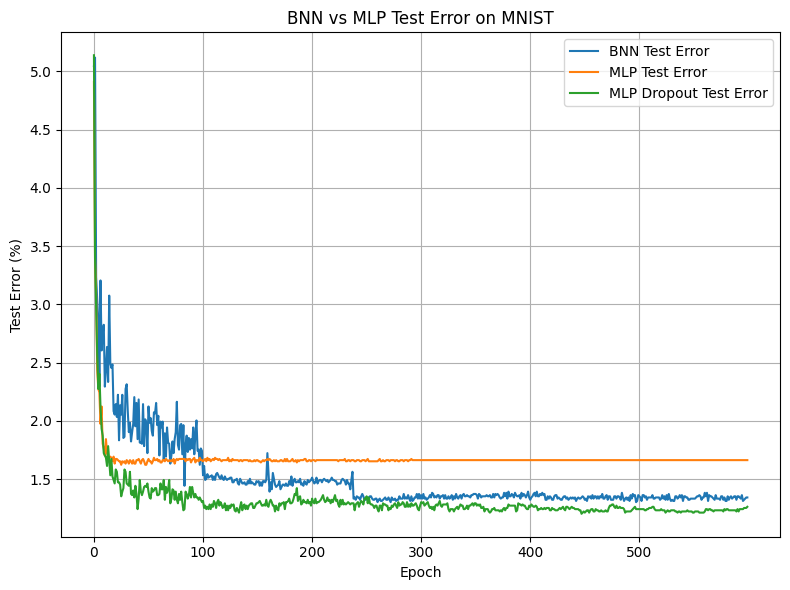

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt

def class_trainer():
    config = ClassConfig
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255 / 126.),
    ])

    train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

    # valid_size = 1 / 6
    # num_train = len(train_data)
    # indices = list(range(num_train))
    # split = int(valid_size * num_train)
    # train_idx, valid_idx = indices[split:], indices[:split]

    # train_sampler = SubsetRandomSampler(train_idx)
    # valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.batch_size, shuffle=False, drop_last=True)

    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'dropout': config.dropout,
        'batch_size': config.batch_size,
        'epochs': config.epochs,
        'x_shape': config.x_shape,
        'classes': config.classes,
        'num_batches': len(train_loader),
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    # Instantiate both models
    bnn_model = BNN_Classification('bnn_classification', {**params})
    mlp_model = MLP_Classification('mlp_classification', {**params, 'dropout': False})
    mlp_dropout_model = MLP_Classification('mlp_dropout_classification', {**params, 'dropout': True})

    bnn_test_errors = []
    mlp_test_errors = []
    mlp_dropout_test_errors = []

    epochs = config.epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        # Train both models
        bnn_model.train_step(train_loader)
        mlp_model.train_step(train_loader)
        mlp_dropout_model.train_step(train_loader)

        # Evaluate on test set
        bnn_test_acc = bnn_model.evaluate(test_loader)
        mlp_test_acc = mlp_model.evaluate(test_loader)
        mlp_dropout_test_acc = mlp_dropout_model.evaluate(test_loader)

        bnn_test_error = 100 * (1 - bnn_test_acc)
        mlp_test_error = 100 * (1 - mlp_test_acc)
        mlp_dropout_test_error = 100 * (1 - mlp_dropout_test_acc)

        bnn_test_errors.append(bnn_test_error)
        mlp_test_errors.append(mlp_test_error)
        mlp_dropout_test_errors.append(mlp_dropout_test_error)

        print(f'BNN Test Error: {bnn_test_error:.2f}%')
        print(f'MLP Test Error: {mlp_test_error:.2f}%')
        print(f'MLP Dropout Test Error: {mlp_dropout_test_error:.2f}%')

        # Learning rate scheduler step if defined
        bnn_model.scheduler.step()
        mlp_model.scheduler.step()
        mlp_dropout_model.scheduler.step()

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(bnn_test_errors, label='BNN Test Error')
    plt.plot(mlp_test_errors, label='MLP Test Error')
    plt.plot(mlp_dropout_test_errors, label='MLP Dropout Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Test Error (%)')
    plt.title('BNN vs MLP Test Error on MNIST')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis ticks every 100 epochs
    epochs = len(bnn_test_errors)
    plt.xticks(ticks=range(0, epochs, 100))
    
    plt.tight_layout()
    plt.show()


class_trainer()





In [11]:
# search_config = {
#     'batch_size': [128],
#     'lr': [1e-3, 1e-4],
#     'epochs': [10],
#     'hidden_units': [1200],
#     'experiment': ['classification'],
#     'dropout': [False],
#     'train_samples': [1, 2, 5],
#     'test_samples': [10],
#     'x_shape': [28 * 28],
#     'classes': [10],
#     'mu_init': [[-0.2, 0.2]],
#     'rho_init': [[-5, -4]],
#     'prior_init': [
#         [0.25, -0, -6],
#         [0.25, -0, -7], 
#         [0.25, -1, -6], 
#         [0.25, -1, -7], 
#         [0.75, -0, -6],
#         [0.75, -0, -7], 
#         [0.75, -1, -6], 
#         [0.75, -1, -7],       
#     ]
# }

# # search_config = {
# #     'batch_size': [128],
# #     'lr': [1e-3, 1e-4],
# #     'epochs': [1], #10
# #     'hidden_units': [1200],
# #     'experiment': ['classification'],
# #     'dropout': [False],
# #     'train_samples': [1],
# #     'test_samples': [10],
# #     'x_shape': [28 * 28],
# #     'classes': [10],
# #     'mu_init': [[-0.2, 0.2]],
# #     'rho_init': [[-5, -4]],
# #     'prior_init': [
# #         [0.25, -0, -6],        
# #     ]
# # }


# import itertools
# from copy import deepcopy

# def generate_param_combinations(param_grid):
#     keys = list(param_grid.keys())
#     values = list(param_grid.values())
#     for combo in itertools.product(*values):
#         yield dict(zip(keys, combo))


# def class_trainer(config):
    
#     transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Lambda(lambda x: x * 255 / 126.),  # divide as in paper, * 255 gives better results
#         ])

#     train_data = datasets.MNIST(
#             root='data',
#             train=True,
#             download=True,
#             transform=transform)
#     # test_data = datasets.MNIST(
#     #         root='data',
#     #         train=False,
#     #         download=True,
#     #         transform=transform)

#     valid_size = 1 / 6

#     num_train = len(train_data)
#     indices = list(range(num_train))
#     split = int(valid_size * num_train)
#     train_idx, valid_idx = indices[split:], indices[:split]

#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)


#     train_loader = torch.utils.data.DataLoader(
#             train_data,
#             batch_size=config['batch_size'],
#             sampler=train_sampler,
#             drop_last=True)
#     valid_loader = torch.utils.data.DataLoader(
#             train_data,
#             batch_size=config['batch_size'],
#             sampler=valid_sampler,
#             drop_last=True)
#     # test_loader = torch.utils.data.DataLoader(
#     #         test_data,
#     #         batch_size=config.batch_size,
#     #         shuffle=False,
#     #         drop_last=True)

#     params = deepcopy(config)
#     params['num_batches'] = len(train_loader)

#     model = BNN_Classification('bnn_classification', {**params})
#     #model = MLP_Classification('mlp_classification', {**params})
    
#     epochs = config['epochs']
#     for epoch in range(epochs):
#             print(f'Epoch {epoch+1}/{epochs}')
#             model.train_step(train_loader)
#             valid_acc = model.evaluate(valid_loader)
#             print('Valid Error', round(100 * (1 - valid_acc), 3), '%',)
#             model.scheduler.step()
#             if model.acc > model.best_acc:
#                 model.best_acc = model.acc
                

#     return model.best_acc, model


In [12]:
# best_val_acc = 0.0
# best_config = None
# best_model = None

# for config in generate_param_combinations(search_config):
#     print(f"Trying config: {config}")
#     val_acc, model = class_trainer(config)

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_config = deepcopy(config)
#         best_model = model

# print("Best Config:")
# print(best_config)
# print(f"Best Validation Accuracy: {best_val_acc:.4f}")

In [13]:
# from tqdm import tqdm
# import numpy as np
# import torch
# from torch.utils.data import SubsetRandomSampler
# from torchvision import datasets, transforms
# from itertools import product

# def class_trainer(config):

#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x * 255. / 126.),
#     ])

#     train_data = datasets.MNIST(
#         root='data',
#         train=True,
#         download=True,
#         transform=transform)
#     test_data = datasets.MNIST(
#         root='data',
#         train=False,
#         download=True,
#         transform=transform)

#     valid_size = 1 / 6
#     num_train = len(train_data)
#     indices = list(range(num_train))
#     split = int(valid_size * num_train)
#     train_idx, valid_idx = indices[split:], indices[:split]

#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)

#     train_loader = torch.utils.data.DataLoader(
#         train_data,
#         batch_size=config['batch_size'],
#         sampler=train_sampler,
#         drop_last=True)
#     valid_loader = torch.utils.data.DataLoader(
#         train_data,
#         batch_size=config['batch_size'],
#         sampler=valid_sampler,
#         drop_last=True)
#     test_loader = torch.utils.data.DataLoader(
#         test_data,
#         batch_size=config['batch_size'],
#         shuffle=False,
#         drop_last=True)

#     params = {
#         'lr': config['lr'],
#         'hidden_units': config['hidden_units'],
#         'experiment': config['experiment'],
#         'batch_size': config['batch_size'],
#         'epochs': config['epochs'],
#         'x_shape': config['x_shape'],
#         'classes': config['classes'],
#         'num_batches': len(train_loader),
#         'train_samples': config['train_samples'],
#         'test_samples': config['test_samples'],
#         'mu_init': config['mu_init'],
#         'rho_init': config['rho_init'],
#         'prior_init': config['prior_init'],
#     }

#     model = BNN_Classification('bnn_classification', {**params, 'dropout': False})

#     best_val_acc = 0
#     for epoch in range(config['epochs']):
#         print(f'Epoch {epoch + 1}/{config["epochs"]}')
#         model.train_step(train_loader)
#         valid_acc = model.evaluate(valid_loader)
#         print('Valid Error', round(100 * (1 - valid_acc), 3), '%')
#         model.scheduler.step()
#         if model.acc > model.best_acc:
#             model.best_acc = model.acc
#             best_val_acc = valid_acc
#             # torch.save(model.net.state_dict(), "best_model.pt")

#     return best_val_acc


In [14]:
# def run_grid_search():
#     # Define the grid
#     param_grid = {
#         'lr': [1e-3, 1e-4],
#         'batch_size': [64, 128],
#         'hidden_units': [128, 256],
#     }

#     # Fixed config options
#     base_config = {
#         'experiment': 'grid_search',
#         'epochs': 5,
#         'x_shape': (1, 28, 28),
#         'classes': 10,
#         'train_samples': 60000,
#         'test_samples': 10000,
#         'mu_init': 0,
#         'rho_init': -3,
#         'prior_init': 0,
#     }

#     best_acc = 0
#     best_params = None

#     # Iterate over all combinations
#     for lr, batch_size, hidden_units in product(param_grid['lr'], param_grid['batch_size'], param_grid['hidden_units']):
#         config = {
#             **base_config,
#             'lr': lr,
#             'batch_size': batch_size,
#             'hidden_units': hidden_units
#         }

#         print(f"\nRunning with config: {config}")
#         acc = class_trainer(config)

#         if acc > best_acc:
#             best_acc = acc
#             best_params = config

#     print(f"Best Validation Accuracy: {best_acc:.4f}")
#     print(f"Best Config: {best_params}")

# run_grid_search()

In [15]:
class BNN_Regression():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.noise_tol = parameters['noise_tolerance']
        self.lr = parameters['lr']
        self.best_loss = np.inf
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init']
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=500, gamma=0.5)
        # print(f'Regression Task {self.label} Parameters: ')
        # print(f'number of samples: {self.n_samples}, noise tolerance: {self.noise_tol}')
        print("BNN Parameters: ")
        print(f'batch size: {self.batch_size}, x shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, mu_init: {parameters["mu_init"]}, rho_init: {parameters["rho_init"]}, prior_init: {parameters["prior_init"]}, lr: {self.lr}')

    def train_step(self, train_data):
        self.net.train()
        for idx, (x, y) in enumerate(train_data):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1) 
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples, sigma=self.noise_tol)
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()
        self.epoch_loss = net_loss.item()

    def evaluate(self, x_test):
        self.net.eval()
        with torch.no_grad():
            y_test = np.zeros((self.test_samples, x_test.shape[0]))
            for s in range(self.test_samples):
                tmp = self.net(x_test.to(device)).detach().cpu().numpy()
                y_test[s,:] = tmp.reshape(-1)
            return y_test

In [16]:
class MLP_Regression():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.best_loss = np.inf
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment
        }
        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print("MLP Parameters: ")
        print(f'batch size: {self.batch_size}, input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def train_step(self, train_data):
        self.net.train()
        for _, (x, y) in enumerate(train_data):
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = torch.nn.functional.mse_loss(self.net(x), y, reduction='sum')
            self.loss_info.backward()
            self.optimiser.step()

        self.epoch_loss = self.loss_info.item()

    def evaluate(self, x_test):
        self.net.eval()
        with torch.no_grad():
            y_test = self.net(x_test.to(device)).detach().cpu().numpy()
            return y_test

In [17]:
# def reg_trainer():
#     config = RegConfig
#     X, Y = create_data_reg(train_size=config.train_size)
#     train_loader = PrepareData(X, Y)
#     train_loader = DataLoader(train_loader, batch_size=config.batch_size, shuffle=True)

#     params = {
#         'lr': config.lr,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'batch_size': config.batch_size,
#         'num_batches': len(train_loader),
#         'x_shape': X.shape[1],
#         'y_shape': Y.shape[1],
#         'train_samples': config.train_samples,
#         'test_samples': config.test_samples,
#         'noise_tolerance': config.noise_tolerance,
#         'mu_init': config.mu_init,
#         'rho_init': config.rho_init,
#         'prior_init': config.prior_init,
#     }

#     model = BNN_Regression('bnn_regression', {**params})
#     #model = MLP_Regression('mlp_regression', {**params})

#     epochs = config.epochs
#     print(f"Initialising training on {device}...")

#     # training loop
#     for epoch in tqdm(range(epochs)):
    
#         model.train_step(train_loader)
#         model.scheduler.step()
#         # save best model
#         if model.epoch_loss < model.best_loss:
#             model.best_loss = model.epoch_loss
#             # torch.save(model.net.state_dict(), model.save_model_path)

#     # evaluate
#     print("Evaluating and generating plots...")
#     x_test = torch.linspace(-2., 2, config.num_test_points).reshape(-1, 1)
    
#     # model.net.load_state_dict(torch.load(model.save_model_path, map_location=torch.device(device)))
#     y_test = model.evaluate(x_test)
    
#     #create_regression_plot(x_test.cpu().numpy(), y_test.reshape(1, -1), train_loader) #per mlp regression
   
#     create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)


# reg_trainer()

In [18]:
# def reg_trainer():
#     config = RegConfig
#     X, Y = create_data_reg(train_size=config.train_size)
#     train_loader = PrepareData(X, Y)
#     train_loader = DataLoader(train_loader, batch_size=config.batch_size, shuffle=True)

#     params = {
#         'lr': config.lr,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'batch_size': config.batch_size,
#         'num_batches': len(train_loader),
#         'x_shape': X.shape[1],
#         'y_shape': Y.shape[1],
#         'train_samples': config.train_samples,
#         'test_samples': config.test_samples,
#         'noise_tolerance': config.noise_tolerance,
#         'mu_init': config.mu_init,
#         'rho_init': config.rho_init,
#         'prior_init': config.prior_init,
#     }

#     #model = BNN_Regression('bnn_regression', {**params})
#     model = MLP_Regression('mlp_regression', {**params})

#     epochs = config.epochs
#     print(f"Initialising training on {device}...")

#     # training loop
#     for epoch in tqdm(range(epochs)):
    
#         model.train_step(train_loader)
#         model.scheduler.step()
#         # save best model
#         if model.epoch_loss < model.best_loss:
#             model.best_loss = model.epoch_loss
#             # torch.save(model.net.state_dict(), model.save_model_path)

#     # evaluate
#     print("Evaluating and generating plots...")
#     x_test = torch.linspace(-2., 2, config.num_test_points).reshape(-1, 1)
    
#     # model.net.load_state_dict(torch.load(model.save_model_path, map_location=torch.device(device)))
#     y_test = model.evaluate(x_test)
    
#     create_regression_plot(x_test.cpu().numpy(), y_test.reshape(1, -1), train_loader) #per mlp regression
   
#     #create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)


# reg_trainer()

In [19]:
'''
Defines base class for contextual bandits
'''
import torch
import numpy as np



class Bandit():
    def __init__(self, label, bandit_params, x, y):
        self.n_samples = bandit_params['n_samples']
        self.buffer_size = bandit_params['buffer_size']
        self.batch_size = bandit_params['batch_size']
        self.num_batches = bandit_params['num_batches']
        self.lr = bandit_params['lr']
        self.epsilon = bandit_params['epsilon']
        self.cumulative_regrets = [0]
        self.buffer_x, self.buffer_y = [], []
        self.x, self.y = x, y
        self.label = label
        self.init_net(bandit_params)
        self.tp, self.tn, self.fp, self.fn = 0, 0, 0, 0

    def get_agent_reward(self, eaten, edible):
        if not eaten:
            return 0
        if eaten and edible:
            return 5
        elif eaten and not edible:
            return 5 if np.random.rand() > 0.5 else -35

    def get_oracle_reward(self, edible):
        return 5*edible 

    def take_action(self, mushroom):
        context, edible = self.x[mushroom], self.y[mushroom]
        eat_tuple = torch.FloatTensor(np.concatenate((context, [1, 0]))).unsqueeze(0).to(device)
        reject_tuple = torch.FloatTensor(np.concatenate((context, [0, 1]))).unsqueeze(0).to(device)

        # evaluate reward for actions
        with torch.no_grad():
            self.net.eval()
            reward_eat = sum([self.net(eat_tuple) for _ in range(self.n_samples)]).item()
            reward_reject = sum([self.net(reject_tuple) for _ in range(self.n_samples)]).item()

        eat = reward_eat > reward_reject
        # epsilon-greedy agent
        if np.random.rand() < self.epsilon:
            eat = (np.random.rand() < 0.5)
        agent_reward = self.get_agent_reward(eat, edible)

        # record bandit action
        if edible and eat:
            self.tp += 1
        elif edible and not eat:
            self.fn += 1
        elif not edible and eat:
            self.fp += 1
        else:
            self.tn += 1

        # record context, action, reward
        action = torch.Tensor([1, 0] if eat else [0, 1])
        self.buffer_x.append(np.concatenate((context, action)))
        self.buffer_y.append(agent_reward)

        # calculate regret
        regret = self.get_oracle_reward(edible) - agent_reward
        self.cumulative_regrets.append(self.cumulative_regrets[-1]+regret)

    def update(self, mushroom):
        self.take_action(mushroom)
        l = len(self.buffer_x)

        if l <= self.batch_size:
            idx_pool = int(self.batch_size//l + 1)*list(range(l))
            idx_pool = np.random.permutation(idx_pool[-self.batch_size:])
        elif l > self.batch_size and l < self.buffer_size:
            idx_pool = int(l//self.batch_size)*self.batch_size
            idx_pool = np.random.permutation(list(range(l))[-idx_pool:])
        else:
            idx_pool = np.random.permutation(list(range(l))[-self.buffer_size:])

        context_pool = torch.Tensor([self.buffer_x[i] for i in idx_pool]).to(device)
        value_pool = torch.Tensor([self.buffer_y[i] for i in idx_pool]).to(device)
        
        for i in range(0, len(idx_pool), self.batch_size):
            self.loss_info = self.loss_step(context_pool[i:i+self.batch_size], value_pool[i:i+self.batch_size], i//self.batch_size)


In [20]:
'''
Two Contextual bandits 
1) BNN and Thompson Sampling -> BNN_Bandit
2) MLP and epsilon-greedy poligy -> Greedy_Bandit
Both derived from base_bandit.py class
'''
import torch
import numpy as np

class BNN_Bandit(Bandit):
    def __init__(self, label, *args):
        super().__init__(label, *args)

    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x.shape[1]+2,
            'classes': 1 if len(self.y.shape)==1 else self.y.shape[1],
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init']
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print(f'Bandit {self.label} Parameters: ')
        print(f'buffer_size: {self.buffer_size}, batch size: {self.batch_size}, number of samples: {self.n_samples}, epsilon: {self.epsilon}')
        print("BNN Parameters: ")
        print(f'input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def loss_step(self, x, y, batch_id):
        beta = 2 ** (self.num_batches - (batch_id + 1)) / (2 ** self.num_batches - 1) 
        self.net.train()
        self.net.zero_grad()
        loss_info = self.net.sample_elbo(x, y, beta, self.n_samples)
        net_loss = loss_info[0]
        net_loss.backward()
        self.optimiser.step()
        return loss_info


class Greedy_Bandit(Bandit):
    def __init__(self, label, *args):
        super().__init__(label, *args)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x.shape[1]+2,
            'classes': 1 if len(self.y.shape)==1 else self.y.shape[1],
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment']
        }
        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print(f'Bandit {self.label} Parameters: ')
        print(f'buffer_size: {self.buffer_size}, batch size: {self.batch_size}, number of samples: {self.n_samples}, epsilon: {self.epsilon}')
        print("MLP Parameters: ")
        print(f'input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def loss_step(self, x, y, batch_id):
        self.net.train()
        self.net.zero_grad()
        net_loss = torch.nn.functional.mse_loss(self.net(x).squeeze(), y, reduction='sum')
        net_loss.backward()
        self.optimiser.step()
        return net_loss

In [21]:
import matplotlib.pyplot as plt

def rl_trainer():
    config = RLConfig
    X, Y = read_data_rl(config.data_dir)

    params = {
        'buffer_size': config.buffer_size,
        'batch_size': config.batch_size,
        'num_batches': config.num_batches,
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init
    }

    bnn_bandit = BNN_Bandit('bnn_bandit', {**params, 'n_samples':2, 'epsilon':0}, X, Y)
    greedy_bandit = Greedy_Bandit('greedy_bandit', {**params, 'n_samples':1, 'epsilon':0}, X, Y)
    greedy_bandit_001 = Greedy_Bandit('greedy_bandit_001', {**params, 'n_samples':1, 'epsilon':0.01}, X, Y)
    greedy_bandit_005 = Greedy_Bandit('greedy_bandit_005', {**params, 'n_samples':1, 'epsilon':0.05}, X, Y)
    
    
    training_steps = config.training_steps
    print(f"Initialising training on {device}...")
    training_data_len = len(X)
    for step in tqdm(range(training_steps)):
        mushroom = np.random.randint(training_data_len)
        bnn_bandit.update(mushroom)
        greedy_bandit.update(mushroom)
        greedy_bandit_001.update(mushroom)
        greedy_bandit_005.update(mushroom)
        
        bnn_bandit.scheduler.step()
        greedy_bandit.scheduler.step()
        greedy_bandit_001.scheduler.step()
        greedy_bandit_005.scheduler.step()

    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    plt.plot(bnn_bandit.cumulative_regrets, label='BNN Cumulative Regret')
    plt.plot(greedy_bandit.cumulative_regrets, label='Greedy Cumulative Regret')
    plt.plot(greedy_bandit_001.cumulative_regrets, label='Greedy 0.01 Cumulative Regret')
    plt.plot(greedy_bandit_005.cumulative_regrets, label='Greedy 0.05 Cumulative Regret')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Regret')
    plt.title('BNN vs Greedy Cumulative Regret over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#rl_trainer()